# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [194]:

import seaborn as sns

### Define functions

In [195]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [196]:
# temp cell

In [197]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [198]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head(n=30)
df

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70.00,Austria,3.75,Blend,Peru
1791,Zotter,Congo,749,2011,65.00,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65.00,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62.00,Austria,3.25,Blend,India


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [199]:
# YOUR CODE HERE

print(f"The dataset has {df.shape[1]} columns.")
print(f"The dataset has {df.shape[0]} rows.")

print(50*'-')
print("The column names are:")
for col_name in df.columns:
    print(col_name)
#print(f"The column names are:\n{[print(col_name) for col_name in df.columns]}")

print(50*'-')
print("The number of unique values in each column:")
for col_name in df.columns:
    print(f"Unique values in '{col_name}': {len(df[col_name].unique())}")
#len(df.maker.unique())
#df.columns
print(50*'-')
print(f"'cocoa_percent' has {len(df.cocoa_percent.unique())} unique values.")

The dataset has 9 columns.
The dataset has 1795 rows.
--------------------------------------------------
The column names are:
maker
specific_origin
reference_number
review_date
cocoa_percent
maker_location
rating
bean_type
broad_origin
--------------------------------------------------
The number of unique values in each column:
Unique values in 'maker': 414
Unique values in 'specific_origin': 1038
Unique values in 'reference_number': 440
Unique values in 'review_date': 12
Unique values in 'cocoa_percent': 45
Unique values in 'maker_location': 58
Unique values in 'rating': 13
Unique values in 'bean_type': 39
Unique values in 'broad_origin': 160
--------------------------------------------------
'cocoa_percent' has 45 unique values.


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here: 

In [200]:
# YOUR CODE HERE
df.info()
print(df.maker_location.value_counts())
#fig, ax = plt.subplots(figsize=(25, 10))
#ax.hist(df.maker_location, bins=58)

print(df.maker_location.unique())
#plt.xticks(df.maker_location, rotation=90)

a = df.maker_location.value_counts().sort_values(ascending=False).head(20)
a.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   maker             1795 non-null   object 
 1   specific_origin   1795 non-null   object 
 2   reference_number  1795 non-null   int64  
 3   review_date       1795 non-null   int64  
 4   cocoa_percent     1795 non-null   float64
 5   maker_location    1795 non-null   object 
 6   rating            1795 non-null   float64
 7   bean_type         1795 non-null   object 
 8   broad_origin      1795 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB
maker_location
U.S.A.         764
France         156
Canada         125
England         96
Italy           63
              ... 
India            1
Philippines      1
Ghana            1
Eucador          1
Suriname         1
Name: count, Length: 58, dtype: int64
['France' 'U.S.A.' 'Fiji' 'Ecuador' 'Mexico' 'Switz

maker_location
U.S.A.         764
France         156
Canada         125
England         96
Italy           63
Ecuador         54
Australia       49
Belgium         40
Switzerland     38
Germany         35
Austria         26
Spain           25
Colombia        23
Hungary         22
Venezuela       20
Name: count, dtype: int64

In [201]:

region_mapping = {
    # North America (Canada, USA, Mexico)
    'U.S.A.': 'North America',
    'Canada': 'North America',
    'Mexico': 'North America',

    # Western Europe (including Italy)
    'France': 'Western Europe',
    'Switzerland': 'Western Europe',
    'Netherlands': 'Western Europe',
    'Spain': 'Western Europe',
    'Italy': 'Western Europe',
    'Belgium': 'Western Europe',
    'Germany': 'Western Europe',
    'England': 'Western Europe',
    'Wales': 'Western Europe',
    'Scotland': 'Western Europe',
    'Portugal': 'Western Europe',
    'Denmark': 'Western Europe',
    'Sweden': 'Western Europe',
    'Austria': 'Western Europe',
    'Finland': 'Western Europe',
    'Iceland': 'Western Europe',
    'Ireland': 'Western Europe',

    # Rest of the World (All others)
    'Poland': 'Rest of the World',   # Central/Eastern Europe
    'Hungary': 'Rest of the World',  # Central Europe
    'Czech Republic': 'Rest of the World',
    'Lithuania': 'Rest of the World',  # Baltic region
    'Russia': 'Rest of the World',  # Eastern Europe
    'Costa Rica': 'Rest of the World',  # Central America
    'Puerto Rico': 'Rest of the World',
    'Honduras': 'Rest of the World',
    'Nicaragua': 'Rest of the World',
    'Guatemala': 'Rest of the World',
    'Dominican Republic': 'Rest of the World',
    'Fiji': 'Rest of the World',
    'Ecuador': 'Rest of the World',
    'Peru': 'Rest of the World',
    'Brazil': 'Rest of the World',
    'Venezuela': 'Rest of the World',
    'Colombia': 'Rest of the World',
    'Japan': 'Rest of the World',
    'New Zealand': 'Rest of the World',
    'South Korea': 'Rest of the World',
    'Martinique': 'Rest of the World',
    'Sao Tome': 'Rest of the World',
    'Argentina': 'Rest of the World',
    'South Africa': 'Rest of the World',
    'Bolivia': 'Rest of the World',
    'St. Lucia': 'Rest of the World',
    'Singapore': 'Rest of the World',
    'Vietnam': 'Rest of the World',
    'Grenada': 'Rest of the World',
    'Israel': 'Rest of the World',
    'India': 'Rest of the World',
    'Madagascar': 'Rest of the World',
    'Philippines': 'Rest of the World',
    'Chile': 'Rest of the World',
    'Ghana': 'Rest of the World',
    'Eucador': 'Rest of the World',  # Assuming typo for "Ecuador"
    'Suriname': 'Rest of the World'
}

df['maker_region'] = df['maker_location'].map(region_mapping).fillna('Rest of the World')


In [202]:
df.maker_region.value_counts()
#df.maker_region.isna().sum()
#df.maker_location.value_counts()

maker_region
North America        893
Western Europe       530
Rest of the World    372
Name: count, dtype: int64

In [203]:
df_encoded = pd.get_dummies(df, columns=['maker_region'])

#one_hot_cols = [col in df_encoded.columns if ''
df_encoded.rename(columns={
                            'maker_region_North America': 'north_america',
                            'maker_region_Western Europe': 'west_europe',
                            'maker_region_Rest of the World': 'rest_of_the_world'
                                },                  
                inplace=True)

outcome_cols = ['north_america', 'west_europe', 'rest_of_the_world']
df_encoded[outcome_cols] = df_encoded[outcome_cols].astype(int)
df_encoded.info()
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   maker              1795 non-null   object 
 1   specific_origin    1795 non-null   object 
 2   reference_number   1795 non-null   int64  
 3   review_date        1795 non-null   int64  
 4   cocoa_percent      1795 non-null   float64
 5   maker_location     1795 non-null   object 
 6   rating             1795 non-null   float64
 7   bean_type          1795 non-null   object 
 8   broad_origin       1795 non-null   object 
 9   north_america      1795 non-null   int64  
 10  rest_of_the_world  1795 non-null   int64  
 11  west_europe        1795 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 168.4+ KB


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,north_america,rest_of_the_world,west_europe
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome,0,0,1
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,0,0,1
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,0,0,1
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0,0,1
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0,0,1


In [204]:
# Decision
# Encode bean types to 3 using one-hot 

df_encoded.specific_origin.value_counts()

df_encoded.broad_origin.value_counts().head(15)

df_encoded.bean_type.value_counts().head(15)

bean_type
Blend                     929
Trinitario                419
Criollo                   153
Forastero                  87
Forastero (Nacional)       52
Criollo, Trinitario        48
Forastero (Arriba)         37
Criollo (Porcelana)        10
Forastero (Parazinho)       8
Forastero (Arriba) ASS      6
Beniano                     3
Matina                      3
Nacional (Arriba)           3
EET                         3
Criollo (Ocumare 61)        2
Name: count, dtype: int64

In [205]:
bean_type_mapping = {'Blend': 'Blend',
                     'Trinitario': 'Trinitario'}
df_encoded['bean_type'] = df_encoded['bean_type'].map(bean_type_mapping).fillna('other')

In [206]:
df_encoded.bean_type.value_counts()

bean_type
Blend         929
other         447
Trinitario    419
Name: count, dtype: int64

In [207]:
df_encoded = pd.get_dummies(df_encoded, columns=['bean_type'])

In [208]:
df_encoded.columns[-1]
df_encoded.drop(columns='bean_type_other', inplace=True)

In [209]:
df_encoded.rename(columns={'bean_type_Blend': 'blend_bean',
                           'bean_type_Trinitario': 'trinitario_bean'},
                    inplace=True)

bean_type_cols = ['blend_bean', 'trinitario_bean']

df_encoded[bean_type_cols] = df_encoded[bean_type_cols].astype(int)
df_encoded

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,broad_origin,north_america,rest_of_the_world,west_europe,blend_bean,trinitario_bean
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Sao Tome,0,0,1,1,0
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Togo,0,0,1,1,0
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Togo,0,0,1,1,0
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Togo,0,0,1,1,0
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Peru,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70.00,Austria,3.75,Peru,0,0,1,1,0
1791,Zotter,Congo,749,2011,65.00,Austria,3.00,Congo,0,0,1,0,0
1792,Zotter,Kerala State,749,2011,65.00,Austria,3.50,India,0,0,1,0,0
1793,Zotter,Kerala State,781,2011,62.00,Austria,3.25,India,0,0,1,1,0


In [210]:
df_encoded.broad_origin.value_counts()


#df_encoded.broad_origin = df_encoded.broad_origin.map(region_mapping)
df_encoded.broad_origin.value_counts()
df_encoded.broad_origin.unique()

array(['Sao Tome', 'Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama',
       'Madagascar', 'Brazil', 'Ecuador', 'Colombia', 'Burma',
       'Papua New Guinea', 'Bolivia', 'Fiji', 'Mexico', 'Indonesia',
       'Trinidad', 'Vietnam', 'Nicaragua', 'Tanzania',
       'Dominican Republic', 'Ghana', 'Belize', 'Nine', 'Jamaica',
       'Grenada', 'Toscano Black', 'Guatemala', 'Honduras', 'Costa Rica',
       'Haiti', 'Congo', 'Philippines', 'Houseblend', 'Malaysia',
       'Nature', 'Dominican Republic,Bali', 'Organic Dark',
       'Venezuela,Africa,Brasil,Peru,Mexico', 'Gabon', 'Ivory Coast',
       'Carribean', 'One Hundred', 'Sri Lanka', 'Blend', 'Puerto Rico',
       'Lago di Como,Blu', 'Uganda', 'Blend No 1',
       'Philly Blend,5 plantations', 'Kendari', 'Tarakan', 'Maragda',
       'Martinique', 'Sao Tome,Principe', 'Sensations Intense', 'Vanuatu',
       'Australia', 'Zorzal Reserva,2015 H,Kerchner', 'Liberia',
       'Ecuador,Costa Rica', 'West Africa', 'Hawaii', 'Noir', 'Ilblend',
    

---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [211]:
# YOUR CODE HERE

# Shuffle
#indices = range(0, df.shape[0])
np.random.seed(19)
indices = np.arange(0, df.shape[0])

indices
shuffled_indices = np.random.permutation(indices)
shuffled_indices

df_encoded_shuffle = df_encoded.reindex(shuffled_indices)
df_encoded_shuffle
#df2.bean_type.unique()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,broad_origin,north_america,rest_of_the_world,west_europe,blend_bean,trinitario_bean
1547,Soma,Black Science Blend 1,607,2010,70.00,Canada,3.75,"Dominican Republic,Ecuador,Peru",1,0,0,0,0
1409,Rozsavolgyi,Principe,765,2011,77.00,Hungary,2.75,Principe,0,1,0,0,0
1144,Molucca,Indonesia,1618,2015,70.00,U.S.A.,2.75,Indonesia,1,0,0,1,0
746,Guido Castagna,"Trinidad,Tobago",355,2009,64.00,Italy,3.00,"Trinidad,Tobago",0,0,1,1,0
401,Chocolate Conspiracy,Peru,1259,2014,74.00,U.S.A.,2.75,Peru,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,La Maison du Chocolat (Valrhona),"Porcelana,Pariguan",346,2009,69.00,France,3.50,Venezuela,0,0,1,0,0
1378,Ritual,"Camino Verde P,2012,Balao,Guayas",967,2012,75.00,U.S.A.,3.25,Ecuador,1,0,0,0,0
757,Guittard,Trinidad,552,2010,65.00,U.S.A.,3.00,Trinidad,1,0,0,0,1
622,Enric Rovira (Claudio Corallo),Terreiro Velho P,565,2010,80.00,Spain,3.25,"Sao Tome,Principe",0,0,1,0,0


In [212]:
X = df_encoded_shuffle.drop(columns=outcome_cols)
Y = df_encoded_shuffle[outcome_cols]

print(X.head())
Y.head()
#X_train_val, X_test, Y_train_val, Y_test = 
#df_encoded_shuffle

                     maker        specific_origin  reference_number  \
1547                  Soma  Black Science Blend 1               607   
1409           Rozsavolgyi               Principe               765   
1144               Molucca              Indonesia              1618   
746         Guido Castagna        Trinidad,Tobago               355   
401   Chocolate Conspiracy                   Peru              1259   

      review_date  cocoa_percent maker_location  rating  \
1547         2010          70.00         Canada    3.75   
1409         2011          77.00        Hungary    2.75   
1144         2015          70.00         U.S.A.    2.75   
746          2009          64.00          Italy    3.00   
401          2014          74.00         U.S.A.    2.75   

                         broad_origin  blend_bean  trinitario_bean  
1547  Dominican Republic,Ecuador,Peru           0                0  
1409                         Principe           0                0  
1144       

,north_america,west_europe,rest_of_the_world
1547,1,0,0
1409,0,0,1
1144,1,0,0
746,0,1,0
401,1,0,0


In [213]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25)

In [214]:
print('X_train shape:', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

print('Y_train shape:', Y_train.shape)
print('Y_val shape', Y_val.shape)
print('Y_test shape', Y_test.shape)




X_train shape: (1077, 10)
X_val shape (359, 10)
X_test shape (359, 10)
Y_train shape: (1077, 3)
Y_val shape (359, 3)
Y_test shape (359, 3)


In [215]:
X_test

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,broad_origin,blend_bean,trinitario_bean
444,Compania de Chocolate (Salgado),Esmeraldas,296,2008,88.00,Argentina,2.75,Ecuador,0,0
1508,Soma,"Sambirano Valley,Black Science,B,603070",1820,2016,70.00,Canada,3.50,Madagascar,0,1
419,Chocovic,"Bolivar,Guaranda",117,2007,71.00,Spain,2.50,Ecuador,0,0
1787,Zotter,Santo Domingo,879,2012,70.00,Austria,3.75,Dominican Republic,1,0
1534,Soma,O'ahu,833,2012,70.00,Canada,3.75,Hawaii,1,0
...,...,...,...,...,...,...,...,...,...,...
1688,Valrhona,Tainori,327,2009,64.00,France,3.75,Dominican Republic,1,0
1359,Raaka,La Red,785,2011,85.00,U.S.A.,3.50,Dominican Republic,1,0
306,Cacao Prieto,Dominican Republic,641,2011,66.00,U.S.A.,3.75,Dominican Republic,1,0
43,Alexandre,"Makwale Village,Kyela",1944,2017,70.00,Netherlands,3.50,Tanzania,0,0


In [216]:
# Features to keep
X_train = X_train[['cocoa_percent', 'rating', 'blend_bean', 'trinitario_bean']]

X_val = X_val[['cocoa_percent', 'rating', 'blend_bean', 'trinitario_bean']]
X_test = X_test[['cocoa_percent', 'rating', 'blend_bean', 'trinitario_bean']]



In [217]:
def standardize(inputs, training_data):
    """  
    Return standardized max-min array 
    Args:
        inputs: a numpy array
        training_data: training data (features or outcome) used to calculate location and scale
    """
    return (inputs  - np.min(a=training_data, axis=0, keepdims=True)) / (np.max(a=training_data, axis=0, keepdims=True) - np.min(a=training_data, axis=0, keepdims=True))



In [218]:
X_train = X_train.values
X_val = X_val.values 
X_test = X_test.values

Y_train = Y_train.values
Y_val = Y_val.values 
Y_test = Y_test.values



In [219]:
X_val

array([[76.  ,  3.  ,  0.  ,  0.  ],
       [75.  ,  2.5 ,  0.  ,  0.  ],
       [90.  ,  2.  ,  0.  ,  0.  ],
       ...,
       [72.  ,  3.25,  0.  ,  1.  ],
       [70.  ,  3.75,  0.  ,  1.  ],
       [71.  ,  2.5 ,  0.  ,  1.  ]])

In [220]:
X_train_scaled = standardize(X_train, X_train)
X_val_scaled = standardize(X_val, X_train)
X_test_scaled = standardize(X_test, X_train)
X_train_scaled

array([[0.48275862, 0.75      , 1.        , 0.        ],
       [0.22413793, 0.66666667, 1.        , 0.        ],
       [0.51724138, 0.58333333, 1.        , 0.        ],
       ...,
       [0.37931034, 0.66666667, 1.        , 0.        ],
       [0.56896552, 0.75      , 0.        , 1.        ],
       [0.51724138, 0.66666667, 0.        , 1.        ]])

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

(array([  3.,   5.,   2.,  19.,   8., 234., 211., 183., 231., 181.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

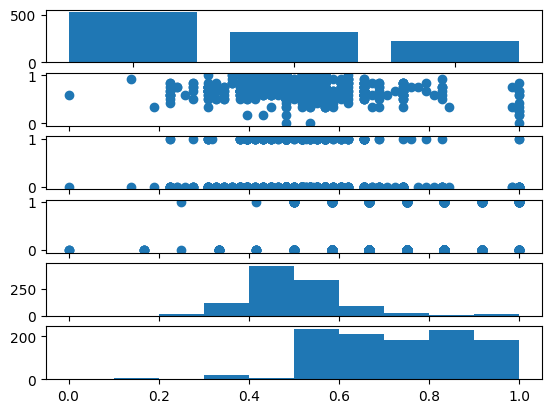

In [231]:
# YOUR CODE HERE
Y_labels = np.argmax(Y_train, axis=1)
Y_labels[0:15]

Y_label_name = ['North America', 'Rest of the World', 'Western Europe']

maker_region_classes, counts = np.unique(Y_labels, return_counts=True)
fig, ax = plt.subplots(6, 1)

ax[0].bar(maker_region_classes, counts, tick_label=[f'{Y_label_name[i]}' for i in maker_region_classes])

ax[1].scatter(X_train_scaled[:,0], X_train_scaled[:,1])

ax[2].scatter(X_train_scaled[:,0], X_train_scaled[:,3])

ax[3].scatter(X_train_scaled[:,1], X_train_scaled[:,3])

ax[4].hist(X_train_scaled[:,0])

ax[5].hist(X_train_scaled[:,1])

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [21]:
# YOUR CODE HERE

### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

In [ ]:
# My own implementation - to keep


In [22]:
# YOUR CODE HERE

---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). 

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

In [239]:
# YOUR CODE HERE

def build_model(num_features, learning_rate):
    """Build a TF multi-class logistic regression model using Keras.

    Args:
        num_features: The number of input features.
        learning_rate: The desired learning rate for SGD.

    Returns:
        model: A tf.keras model (graph).
    """
    # Clear previous models and set a random seed
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build the model
    model = tf.keras.Sequential()


        # 🔹 First Hidden Layer (128 nodes, ReLU activation)
    model.add(tf.keras.layers.Dense(
        units=128,                     # Number of neurons
        input_shape=(num_features,),   # Input shape (features)
        activation='relu',             # ReLU activation for hidden layers
        kernel_initializer='he_normal' # Recommended for ReLU
    ))

    # 🔹 Second Hidden Layer (64 nodes)
    model.add(tf.keras.layers.Dense(
        units=64,
        activation='relu'
    ))

    # 🔹 Output Layer (3 nodes for 3-class classification)
    model.add(tf.keras.layers.Dense(
        units=3,         
        activation='softmax'  # Multi-class classification
    ))

#   model.add(tf.keras.layers.Dense(
#       units=3,                   # Output dimension = number of classes (3)
#       input_shape=(num_features,),  # Input features
#       use_bias=True,               # Use bias term
#       activation='softmax',        # Multi-class classification
#       kernel_initializer='ones',  # Initialize weights to 1
#       bias_initializer='ones',    # Initialize bias to 1
#   ))

    # Use SGD optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',  # Multi-class classification loss
                  metrics=['accuracy'])

    return model


In [243]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE

# Build and compile
model_tf = build_model(num_features=X_train_scaled.shape[1],
                       learning_rate=0.001)

# 3. Fit the model
# YOUR CODE HERE
# Fit the model with specified hyperparameters
history = model_tf.fit(X_train_scaled, Y_train,
             epochs=150,
             batch_size=32,
             validation_data=(X_val_scaled, Y_val),
             verbose=1)


Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2627 - loss: 1.2235 - val_accuracy: 0.2897 - val_loss: 1.1456
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3395 - loss: 1.1193 - val_accuracy: 0.4513 - val_loss: 1.0786
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4294 - loss: 1.0772 - val_accuracy: 0.5097 - val_loss: 1.0470
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4806 - loss: 1.0585 - val_accuracy: 0.5237 - val_loss: 1.0303
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4929 - loss: 1.0489 - val_accuracy: 0.5320 - val_loss: 1.0205
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4882 - loss: 1.0432 - val_accuracy: 0.5348 - val_loss: 1.0144
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4938 - loss: 1.0394 - val_accuracy: 0.5348 - val_loss: 1.0102
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4943 - loss: 1.0365 - val_accuracy: 0.5348 - v

---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [24]:
# YOUR CODE HERE

### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

In [25]:
# YOUR CODE HERE

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [26]:
# YOUR CODE HERE